In [1]:
%pylab inline
import pandas as pd
import numpy as np

import torch
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import torch.optim as optim                          # optimization

import os
from tqdm import tqdm                                # for progress bar
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_rand_score

from clustering import clus

from numba import njit

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the gpu")
else:
    device = torch.device("cpu")
    print("running on the cpu")
    
from scDHA import scDHA

Populating the interactive namespace from numpy and matplotlib
running on the gpu


In [ ]:
path = "goolam"
do_clus = True
latent = scDHA(path, False, vae_choice='paper', retrain=True, seed=1) # a list with 3 differently trained latent variables
print(len(latent), latent[0].shape)


In [ ]:
x = np.load('latent/xin.npy')
print(len(x))

In [ ]:
x = [np.array([1,2,3]), np.array([1,2,3]), np.array([1,2,3])]
x = np.array(x)
print(x)

## classification

In [ ]:
from Analysis import scDHA_class
res = scDHA_class('goolam', seed=1, retrain=False)

# Clustering

ari: 0.5448686870439825


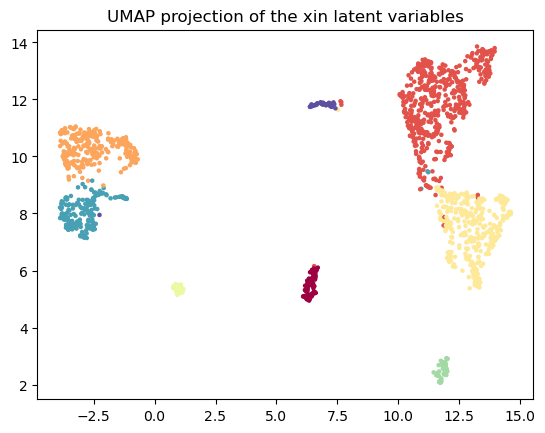

In [1]:
from Analysis import scDHA_vis, scDHA_clus
_, _ = scDHA_clus('xin', 8)
scDHA_vis('xin', 8)


In [ ]:

if do_clus:
    # Use an ensemble of data projection models to achieve higher accuracy and to avoid local minima, not needed if we use kmeans++
    # first repeat the data projection
    labels = []
    for hidden in latent:
        # labels.append(clus(hidden, k=6, nmax=100))
        labels.append(clus(hidden, nmax=50))
    labels = np.array(labels) 
    print(labels)   
    S = np.zeros((len(labels), len(labels)))  # chance that cell i and j are in the same cluster
    for i, row in enumerate(S):
        for j, _ in enumerate(S):
            if not (i==j):
                S[i, j] = adjusted_rand_score(labels[i], labels[j])
    for i, row in enumerate(S):
        S[i,i] = row.mean()
    print(S)
    found = False
    if (S[S < 0.7]).sum() > 0:
        i = 2
    else:
        i = 1
        
    # find best guessed label (latent variable)
    while not found:
        # print(f'i={i}')
        tmp = KMeans(n_clusters = i, n_init = 100, max_iter = 5000).fit(S)
        k = tmp.labels_
        max = 0
        for c in range(tmp.cluster_centers_.shape[0]): # for k clusters
            score = S[k == c, k == c].mean()
            if score > max and (k==c).sum() > 1:
                max = score
                idx = (k == c)
        if max > 0.8:
            found = True
        if i >= 3:
            found = True
        
        i += 1
    # guess number of clusters
    tmp = []
    for label in labels[idx]:
        tmp.append(np.unique(label).shape[0])
        print(tmp)
    cluster_max = np.floor(np.mean(tmp)+0.5).astype(np.int)
    
    
    # (i) calculate cell-cell weighted similarity matrix 
    W = S * (1 - S)
    print(W.max(), W.min())
    # then combine the clustering results using the wMetaC
    # wMetaC = AgglomerativeClustering(n_clusters=k_classes, linkage='ward')
    # # wMetaC = AgglomerativeClustering(n_clusters=k_classes, affinity='precomputed')
    # wMetaC.fit(latent)
    # # wMetaC.fit(clustered.affinity_matrix_.toarray())
    # print(wMetaC)
    # print(clustered.labels_)
    # print(wMetaC.labels_)

        # print(latent.size())
    
    
